In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dropbox_dir = r'/Users/kendraziegler/Dropbox (Palmer Lab)/PalmerLab_Datasets/sample_tracking/files_received/wfu_master/'
current_project = 'p50_paul_meyer_2020'
raw_dir = dropbox_dir + current_project


In [3]:
projects = ['/Paul #7 Shipping Sheet.xlsx','/Paul #8 Shipping Sheet 40 pilots.xlsx','/Paul #9 Shipping Sheet.xlsx','/Paul #10 Shipping Sheet.xlsx','/Paul #11 Shipping Sheet.xlsx']
project = projects[2]
data = pd.read_excel(raw_dir + project)

        

In [4]:
projects = ['p50_david_dietz_2020','p50_hao_chen_2020','p50_hao_chen_2020_rnaseq','p50_paul_meyer_2020',
            'u01_olivier_george_cocaine', 'u01_olivier_george_oxycodone', 'u01_olivier_george_scrub',
            'u01_peter_kalivas_italy', 'u01_peter_kalivas_us', 'u01_suzanne_mitchell', 'u01_tom_jhou' ]
def runQuery(query):

    cursor = connection.cursor()
    if "SELECT" in query:
        table = pd.read_sql(query, con = connection)
    elif "UPDATE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    elif "DELETE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    else:
        return None
    if connection:
        cursor.close()
        connection.close()
        if "SELECT" in query:
            return table
        else:
            return
#change project here
current_project = projects[3]
wfu_master = runQuery("SELECT * FROM " + current_project + ".wfu_master")




In [5]:
def fixColumns(columns):
    for i in range(len(columns)):
        columns[i] = columns[i].lower().replace(" ", "")
        if "sir" in columns[i] or "father" in columns[i]:
            columns[i] = "sires"
        elif "dam" in columns[i] or "mother" in columns[i]:
            columns[i] = "dames"
        elif "animal" in columns[i] and "id" in columns[i]:
            columns[i] = "labanimalid"
        elif "access" in columns[i] and "id" in columns[i]:
            columns[i] = "accessid"
        elif "sex" in columns[i]:
            columns[i] = "sex"
        elif "rfid" in columns[i] or "ponder" in columns[i]:
            columns[i] = "rfid"
        elif ("d" in columns[i] and "o" in columns[i] and "b" in columns[i]) or "birth" in columns[i]:
            columns[i] = "dob"
        elif ("d" in columns[i] and "o" in columns[i] and "w" in columns[i]) or ("wean" in columns[i] and "date" in columns[i]):
            columns[i] = "dow"
        elif "ship" in columns[i] and "date" in columns[i]:
            columns[i] = "shipmentdate"
        elif "litter" in columns[i] and ("#" in columns[i] or "num" in columns[i]):
            columns[i] = "litternumber"
        elif "ship" in columns[i] and "box" in columns[i]:
            columns[i] = "shipmentbox"
        elif "comment" in columns[i] or "note" in columns[i]:
            columns[i] = "comments"
    return columns

In [6]:
def checkDupCols(data):
    for col in data.columns:
        if ".1" in col:
            data[col] = data[col].astype(str)
            data[col.replace(".1", "")] = data[col.replace(".1", "")].astype(str)
            data[col] = [val.replace(".0", "") for val in data[col]]
            data[col.replace(".1", "")] = [val.replace(".0", "") for val in data[col].replace(".1", "")]
            if list(data[col] == data[col.replace(".1", "")]).count(True) != len(data[col]):
                print("Transponder ID Mismatch found")
                print(data[col])
                print(data[col.replace(".1", "")])
            del data[col]
    return data

In [7]:
#Specific Errors

def date_error(data):
    #Meyer2020 Shipping Sheet #7
    a = (data['dob'] == '4/21/20221')
    data.loc[a,'dob'] = '4/21/2021'
    return data

def comment_error(data):
    #Meyer2020 Shipping Sheet #7
    #data["comments"] = "NA"
    if 'unnamed:18' in data.columns:
        data.loc[data['unnamed:18'] == 'DOUBLE PULLS','unnamed:18'] = np.nan
        data.loc[(data['rfid'] == 'AA1DCD6794'),'comments'] = "DOUBLE PULLS"
        data = data.drop(columns = ['unnamed:18'])
    return data
    
def column_error(data):
    #Meyer2020 Shipping sheet #7
    if '124rats' in data.columns:
        data = data.drop(columns=['124rats'])
    return data

def error_rows(data):
    #Meyer2020 Shipping sheet #7
    #Meyer2020 Shipping sheet #8
    if 'unnamed:5' in data.columns:
        print("Difference between unnamed:5 and rfid")
        display(data.loc[~(data['unnamed:5'] == data['rfid'])])
        print("unnamed:5 value counts")
        display(data['unnamed:5'].value_counts().to_string())
        print("Dropped unnamed:5")
        data = data.drop(columns = ['unnamed:5'])
    return data
        
def error_rfids(data):
    data['rfid'] = data['rfid'].str.upper()

In [8]:
#calculate the weanage and shipment age
def addAge(data, col_name):
    data['dob'] = pd.to_datetime(data['dob'])
    data['dow'] = pd.to_datetime(data['dow'])
    data['shipmentdate'] = pd.to_datetime(data['shipmentdate'])

    if "ship" in col_name:
        i_date = list(data.columns).index("shipmentdate")
    elif "wean" in col_name:
        i_date = list(data.columns).index("dow")
    else:
        print("Invalid col_name provided")
        return None
    values = []
    for index, row in data.iterrows():
        i_dob = list(data.columns).index("dob")
        # Want it to be datetime.date not datetime.datetime
        if not isinstance(data.iloc[index, i_dob], datetime.datetime):
            data.iloc[index, i_dob] = data.iloc[index, i_dob].date()
        if not isinstance(data.iloc[index, i_date], datetime.datetime):
            data.iloc[index, i_date] = data.iloc[index, i_date].date()
        values.append((data.iloc[index, i_date] - data.iloc[index, i_dob]).days)
    return values

In [9]:
#change transponder ID into rfid
def rfid_column():
    if "Transponder ID" in data.columns:
        i = list(data.columns).index("Transponder ID")
        for index, row in data.iterrows():
            data.iloc[index, i] = data.iloc[index, i].upper()
            if data.iloc[index, i][:2] != "AA":
                data.iloc[index, i] = "AA" + data.iloc[index, i]
        checkDupCols(data)
        data.columns = fixColumns(list(data.columns))
#rfid_column()

In [10]:
# Check if data columns look correct
#print("Data columns:", list(data.columns))
#remove NA columns
def drop_na(data):
    list1 = data.columns
    #print(list1)
    data = data.dropna(axis=1, how='all')
    list2 = data.columns
    #print(list2)
    diff = list(set(list1).difference(list2))
    if len(diff) >= 1:
        print("\nData columns dropped due to all NA:", diff)
    return data


In [11]:
def rfid_in_wfu(data):
    data["rfid"] = data["rfid"].astype(str)
    wfu_master_rfids = list(wfu_master["rfid"])
    data_rfids = list(data["rfid"])
    duplicate_rfids = list(set(wfu_master_rfids).intersection(set(data_rfids)))
    print(len(duplicate_rfids), "rfids already in WFU_master, out of", len(data_rfids))
    #print(duplicate_rfids)
    fix = list(set(data_rfids) - set(wfu_master_rfids))


In [12]:
def new_columns(data):
    if True:
        # Making wfu_master and data have same columns
        cohort = "".join(filter(str.isdigit, project))
        if len(cohort) == 1:
            cohort = "0" + cohort
        data["cohort"] = "C" + cohort
        data["shipmentage"] = addAge(data, "shipmentage")
        data["weanage"] = addAge(data, "weanage")
        data["comments"] = "NA"
        data["resolution"] = "NA"
        #data = data[columns_wfu]
        for index, row in data.iterrows():
            for i in range(len(row)):
                if isinstance(data.iloc[index, i], datetime.date):
                    if isinstance(data.iloc[index, i], type(pd.NaT)):
                        data.iloc[index, i] = None
                    else:
                        data.iloc[index, i] = data.iloc[index, i].strftime("%Y/%m/%d")

In [13]:
def column_qc():
    print("\n\nColumn headers for: "+ current_project)
    for column in data.columns:
        print(column)
    common_headers = ['cohort','sires','dames','labanimalid','accessid','sex','rfid','dob','dow','shipmentdate',
                      'litternumber','littersize','coatcolor','earpunch','rack','shipmentbox','shipmentage','weanage',
                      'comments','resolution']
    #find any odd column headers
    for column in data.columns:
        if column not in common_headers:
            print("\nNon uniform column headers:")
            print(column)
    for column in common_headers:
        if column not in data.columns:
            print("\nMissing uniform column header:")
            print(column)


In [14]:
def cohorts(data):
    #print("\nNumber of cohorts for " + current_project + ":")
    #display(len(data['cohort'].value_counts().sort_index()))
    print("\nCohort for " + current_project +", " + project[1:-5] + " and the number of subjects:")
    display(data['cohort'].value_counts().to_string())
    


In [15]:
#count the number of sires and dames in each cohort
#count how many of those sires and dames are unique meaning that multiple sires and dames had more than one child
#check how many parent pairs there are
#Check how many parent pairs are present in multiple cohorts
#check if there is an rfid labeled as both a sire and a dame
#check for missing parents
def qc_pedigree(data):
    sires = list(data["sires"])
    dames = list(data["dames"])
    
    data = data.sort_values(["cohort", "labanimalid"])

    # Printing number of mothers and fathers per cohort
    unique_sires = []
    unique_dames = []
    for cohort in np.unique(data["cohort"]):
        subset = data[data["cohort"] == cohort]
        sires = list(subset["sires"])
        dames = list(subset["dames"])
        unique_sires.append(len(set(sires)))
        unique_dames.append(len(set(dames)))
        print(cohort, "sires", "unique", len(set(sires)))
        print(cohort, "dames", "unique", len(set(dames)))


    # Checking sibling numbers
    parents_dict = {}
    parents_litter_birth = {}
    dob = []
    litter = []
    parents_df = pd.DataFrame()
    for index, row in data.iterrows():
        parents = (row["sires"], row["dames"])
        
        if parents in parents_dict.keys():
            parents_dict[parents].append(row["rfid"])
            parents_litter_birth[parents].append(row["dob"])
        else:
            dob.append(row['dob'])
            litter.append(row['littersize'])
            parents_dict[parents] = [row["rfid"]]
            parents_litter_birth[parents] = [row["dob"]]
            parents_df = parents_df.append({'sires':row["sires"],'dames':row["dames"]},ignore_index = True)
    print("\nparent pairs",len(parents_dict.keys()), '\n')
    siblings = []
    for parents in parents_dict.keys():
        #print(parents, len(parents_dict[parents]))#, parents_dict[parents])
        siblings.append(len(parents_dict[parents]))
        cohorts = []
        for rfid in parents_dict[parents]:
            subset = data[data["rfid"] == rfid]
            subset.index = range(subset.shape[0])
            i_cohort = list(subset.columns).index("cohort")
            cohorts.append(subset.iloc[0, i_cohort])
        cohorts = list(np.unique(cohorts))
        if len(cohorts) != 1:
            print("parent pair across multiple cohorts found", cohorts)
    parents_df['siblings'] = siblings
    parents_df['dob'] = dob
    parents_df['litter_size'] = litter
    #parents_df['removed_litter'] = parents_df['litter_size'] - parents_df['siblings']
    

        
    #Check if there are any matching ids between sires and dames
    overlap = set(dames).intersection(set(sires))
    if len(list(overlap)) > 0:
        print("\nError: listed as dame and sire", list(overlap))
    elif len(list(overlap)) == 0:
        print('\nNo rfids labeled as both a sire and a dame')
    mislabeled_df = pd.DataFrame()
    unique_sires = data.sires.unique()
    unique_dames = data.dames.unique()
    mislabeled = [x for x in unique_sires if x in unique_dames]
    if len(overlap) > 0:
        mislabeled_nan_sires = data[data['sires'].isnull()]
        mislabeled_nan_dames = data[data['dames'].isnull()]
        mislabeled_nan = pd.concat([mislabeled_nan_sires,mislabeled_nan_dames]).drop_duplicates().reset_index(drop=True)
        if len(mislabeled_nan.index) > 0:
            print('\nMissing Sires/Dames for ' + current_project)
            display(mislabeled_nan)
        for rfid in mislabeled:
            mislabeled_df.append(data.loc[data['sires'] == rfid])
            mislabeled_df.append(data.loc[data['dames'] == rfid])
        if len(mislabeled_df.dropna().index) > 0:
            print('Mislabeled Sires/Dames')
            display(mislabeled_df.dropna())
        

    df_missing_sires = data[data.sires == 'None']
    df_missing_dames = data[data.dames == 'None']
    df_missing = pd.concat([df_missing_sires,df_missing_dames]).drop_duplicates().reset_index(drop=True)
    if len(df_missing) > 0:
        print('\nMissing Parents:')
        display(df_missing)
    else:
        print('\nNo missing parents')



In [16]:
def birth_range():
    date_min = min(data['dob'])
    date_max = max(data['dob'])
    date_range = date_max.date() - date_min.date()
    print('\nDOB range(days):', date_range.days)

In [17]:
def wean_range():
    date_min = min(data['dow'])
    date_max = max(data['dow'])
    date_range = date_max - date_min
    print('\nDOW range(days):', date_range.days)

In [18]:
# Fixing coatcolor in sample_metadata
def coat_color(data):
    toFix = []
    metadata = data
    print("\nBefore Coat Color Normalization:")
    display(data['coatcolor'].value_counts().to_frame())

    # metadata = select_wfu_master("u01_olivier_george_oxycodone")
    i_coatcolor = list(metadata.columns).index("coatcolor")
    for index, row in metadata.iterrows():
        coatcolor = data.iloc[index, i_coatcolor]
        if coatcolor == "BLK HOOD":
            coatcolor = "BLACKHOOD"
        elif coatcolor == "BRN HOOD":
            coatcolor = "BROWNHOOD"
        elif coatcolor == "BEN HOOD":
            coatcolor = "BROWNHOOD"
        elif coatcolor == "ALIBINO":
            coatcolor = "ALBINO"
        coatcolor = coatcolor.replace(" ", "")
        if coatcolor != metadata.iloc[index, i_coatcolor]:
            toFix.append(index)
            metadata.iloc[index, i_coatcolor] = coatcolor
    metadata = metadata.iloc[toFix, :]
    metadata.index = range(metadata.shape[0])
    print("\nAfter Coat Color Normalization:")
    display(data['coatcolor'].value_counts().to_frame())

#     if len(metadata.index) > 0:
#         print("Need to normalize following rows for coat color:")
#         display(metadata)


In [35]:
df.columns

Index(['siblings'], dtype='object')

In [19]:
def qc_rfid(rfid, prefix, length):
    # Checking if prefix is present
    if rfid[:len(prefix)] != prefix:
        return False
    # Checking is rfid is correct length
    elif len(rfid) != length:
        return False
    return True
def check_rfid():
    #Check to make sure rfid for the project contains the correct naming convention
    project_metadata = pd.read_csv("project_metadata - project_metadata.csv", dtype = str)
    i_convention = list(project_metadata.columns).index("rfid_convention")
    subset = project_metadata[project_metadata["project_name"] == current_project]
    subset.index = range(subset.shape[0])
    convention_list = subset.iloc[0, i_convention]
    convention_list = convention_list.split(";")
    for i in range(len(convention_list)):
        convention_list[i] = convention_list[i].replace("(", "").replace(")", "").split(",")
    for rfid in data["rfid"]:#data needs to be combination of all projec
        passed = False
        for convention in convention_list:
            prefix = convention[0]
            length = int(convention[1])
            passed = passed + qc_rfid(rfid, prefix, length)
        if not passed:
            print('RFID errors:')
            print(rfid, project)
            display(data.loc[data['rfid']== rfid])

In [47]:
def siblings(data):
    df = data.groupby(['dob','sires','dames'])['siblings'].count().reset_index()
    data['siblings'] = np.nan        
    for index,row in df.iterrows():
        data.loc[(data["dob"] == row['dob']) & (data["sires"] == row['sires']) & (data['dames'] == row['dames']), "siblings"] = row['siblings']
    print("\nSibling value counts:")
    print("\n", data.siblings.value_counts().to_string())
    for index,row in data.iterrows():
        if row['siblings'] > 2:
            print("More than 2 siblings:\n")
            print(data.loc[[index]])
    return data

In [50]:
def graph_columns():
    graph_columns = ['sex','dob','dow','shipmentage','coatcolor','weanage','littersize','litternumber']
    for col in graph_columns:
        plt.title(col)
        plt.xlabel('value')
        plt.ylabel('count')
        plt.xticks(rotation = 40)
        plt.hist(data[col].dropna())
        plt.show() 

91 rfids already in WFU_master, out of 92


Column headers for: p50_paul_meyer_2020
dames
sires
labanimalid
accessid
sex
rfid
dob
dow
shipmentdate
litternumber
littersize
coatcolor
earpunch
rack
shipmentbox
cohort
shipmentage
weanage
comments
resolution
siblings

Non uniform column headers:
siblings

Cohort for p50_paul_meyer_2020, Paul #9 Shipping Sheet and the number of subjects:


'C09    92'

C09 sires unique 46
C09 dames unique 46

parent pairs 46 


No rfids labeled as both a sire and a dame

No missing parents

DOB range(days): 20

DOW range(days): 17

Before Coat Color Normalization:


,coatcolor
BLACKHOOD,28
BLACK,25
BROWN,18
BROWNHOOD,13
ALBINO,8



After Coat Color Normalization:


,coatcolor
BLACKHOOD,28
BLACK,25
BROWN,18
BROWNHOOD,13
ALBINO,8


RFID errors:
WILL NOT READ /Paul #9 Shipping Sheet.xlsx


,dames,sires,labanimalid,accessid,sex,rfid,dob,dow,shipmentdate,litternumber,...,coatcolor,earpunch,rack,shipmentbox,cohort,shipmentage,weanage,comments,resolution,siblings
19,77546_2,77380_1,P865,78613_1,M,WILL NOT READ,2021-08-31,2021-09-20,2021-10-04,4,...,BLACK,RB,A-B2,3,C09,34,20,NA,NA,2.0



Sibling value counts:

 2.0    92


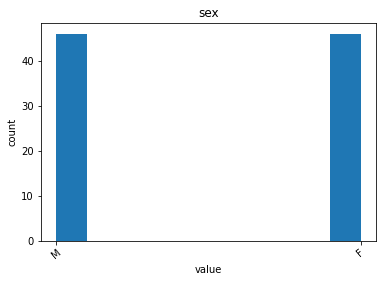

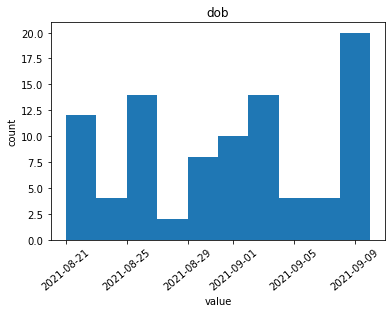

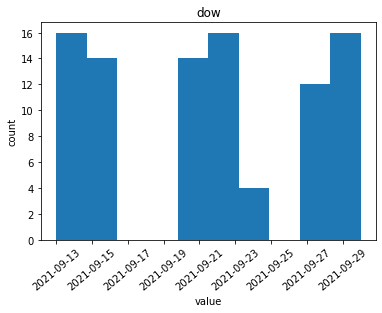

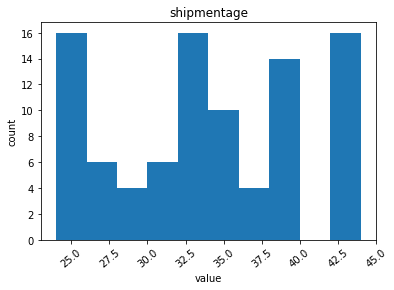

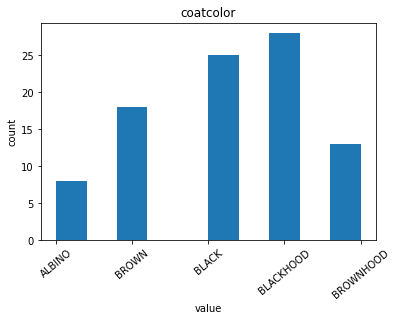

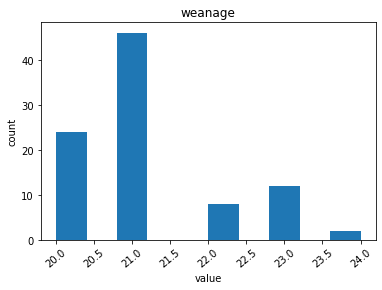

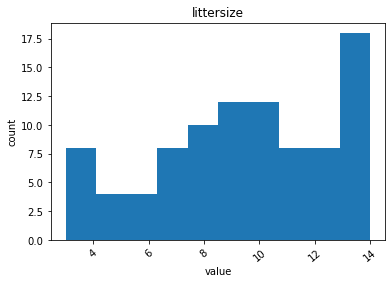

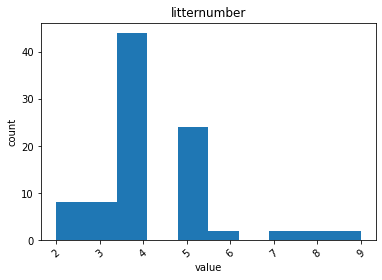

In [51]:
#check duplicate columns
checkDupCols(data)
#fix column names
data.columns = fixColumns(list(data.columns))
#RFIDs already in wfu
rfid_in_wfu(data)
#correct specific errors involving dates
data = date_error(data)
#add column headers to make uniform with wfu
new_columns(data)
#correct specific errors involving comments
data = comment_error(data)
#correct specific errors involving columns
data = column_error(data)
#Drop columns with all NA values
data = drop_na(data)
#column information
column_qc()
#rows with notable errors
data = error_rows(data)
#cohort information
cohorts(data)
#calculate pedigree related information
qc_pedigree(data)
#caluclate the range of birth dates
birth_range()
#calculate the range of wean dates
wean_range()
#qc coat color
coat_color(data)
#error fixing for rfids
error_rfids(data)
#find inccorrect rfids
check_rfid()
#sibling count
data = siblings(data)
#plot relevant graphs
graph_columns()

In [22]:
display(data)

,dames,sires,labanimalid,accessid,sex,rfid,dob,dow,shipmentdate,litternumber,littersize,coatcolor,earpunch,rack,shipmentbox,cohort,shipmentage,weanage,comments,resolution
0,77668_2,77406_1,P828,78576_1,M,AA1DCD689B,2021-08-21,2021-09-13,2021-10-04,3,10,ALBINO,LT,A-A1,1,C09,44,23,NA,NA
1,77479_2,77473_1,P829,78569_1,M,AA1DCD688E,2021-08-21,2021-09-13,2021-10-04,4,14,BROWN,RT,A-A1,1,C09,44,23,NA,NA
2,77155_2,76727_4,P832,78564_4,M,AA1DCD68A5,2021-08-21,2021-09-13,2021-10-04,7,6,BLACK,LT,A-A2,1,C09,44,23,NA,NA
3,77401_1,77446_1,P833,78571_5,M,AA1DCD68CC,2021-08-21,2021-09-13,2021-10-04,3,9,BLACKHOOD,RT,A-A2,1,C09,44,23,NA,NA
4,77550_2,77484_1,P836,78572_2,M,AA1DCD68BD,2021-08-22,2021-09-13,2021-10-04,4,7,ALBINO,LM,A-A3,1,C09,43,22,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,77457_2,77475_1,P911,78651_2,F,AA1DCD68F4,2021-09-09,2021-09-29,2021-10-04,5,10,BLACKHOOD,LCRC,A-F5,12,C09,25,20,NA,NA
88,77375_2,77449_1,P914,78644_2,F,AA1DCD6928,2021-09-09,2021-09-30,2021-10-04,5,11,BLACKHOOD,LTRM,A-F6,12,C09,25,21,NA,NA
89,77485_2,77487_1,P915,78648_2,F,AA1DCD690A,2021-09-09,2021-09-30,2021-10-04,4,14,BROWN,LBRB,A-F6,12,C09,25,21,NA,NA
90,77420_2,77381_1,P918,78653_2,F,AA1DCD6924,2021-09-10,2021-09-30,2021-10-04,5,4,BLACK,LMRM,A-F7,12,C09,24,20,NA,NA
